# **Data analysis**

# **Environment Setup**

In [53]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd
from pathlib import Path

import os
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
import plotly.express as px
import numpy as np

import kaleido


In [54]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['figure.dpi'] = 100
sns.set_style("ticks")
sns.set_theme(
    style="white",
    context="notebook",
    font_scale=1.2,
    rc={
        "font.family": "serif",
        "font.serif": ["Times New Roman", "DejaVu Serif"],
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,
        "mathtext.fontset": "cm",
        "xtick.bottom": True,
        "ytick.left": True,
        "axes.titleweight": "bold",
        "legend.frameon": False,
        "legend.framealpha": 1,
        "legend.facecolor": "white",
        "legend.edgecolor": "black",
        "lines.linewidth": 1.75,
        "axes.linewidth": 1.2,
        "grid.linewidth": 0.6,
        "grid.alpha": 0.8,
        "grid.linestyle": "--",
        "lines.markersize": 5,
    }
)
sns.set_palette("bright")

In [55]:
simulation_path = Path("./")

def get_simulation_parameters(filepath):
    params = {}
    keys = [
        "N", "freeze_mc_steps", "alpha", "density", 
        "charge", "initial_temp", "final_temp", "temp_step"
    ]
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < len(keys):
                value = line.split('!')[0].strip()
                params[keys[i]] = float(value) if i > 0 else int(value)
                
    return params

input_parameters_file = simulation_path / "input_parameters.in"

parameters = get_simulation_parameters(input_parameters_file)
print(parameters) 

{'N': 125, 'freeze_mc_steps': 0.5, 'alpha': 0.5, 'density': 0.1, 'charge': 1.0, 'initial_temp': 1.0, 'final_temp': 0.0001, 'temp_step': 0.98}


<>:4: SyntaxWarning:

invalid escape sequence '\s'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_128865/31057736.py:4: SyntaxWarning:

invalid escape sequence '\s'



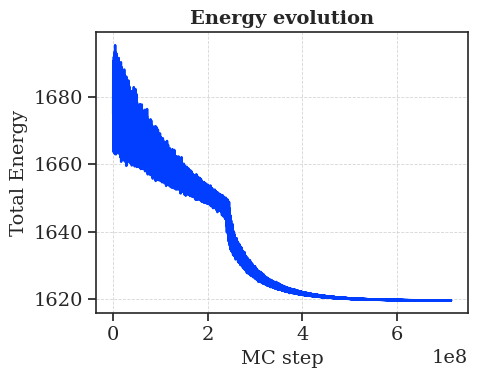

In [56]:

def get_simulation_energy_evolution(simulation_path):
    energy_evolution_file = simulation_path / "energy.out"

    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['mc_step', 'energy', 'temperature', ])
    reset_indices = df['mc_step'].diff() < 0
    offsets = np.where(reset_indices, df['mc_step'].shift(1), 0)
    cumulative_offset = offsets.cumsum()
    df['total_mc_step'] = df['mc_step'] + cumulative_offset

    plt.figure()
    plt.plot(df['total_mc_step'], df['energy'], label='Energía del sistema')
    plt.xlabel('MC step')
    plt.ylabel('Total Energy')
    plt.title('Energy evolution')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "energy_vs_mc_steps.pdf")
    plt.show()
    
get_simulation_energy_evolution(simulation_path)

<>:4: SyntaxWarning:

invalid escape sequence '\s'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_128865/4074179299.py:4: SyntaxWarning:

invalid escape sequence '\s'



Results saved in: result_simulation.csv


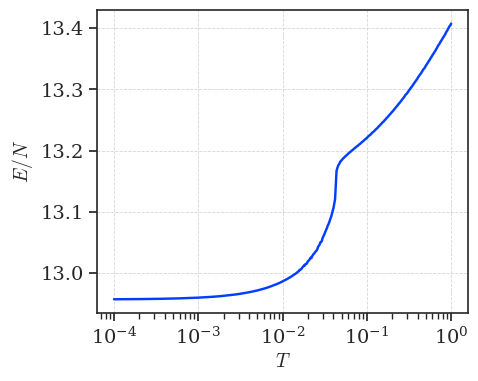

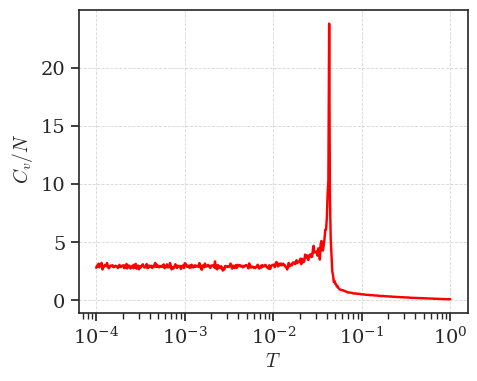

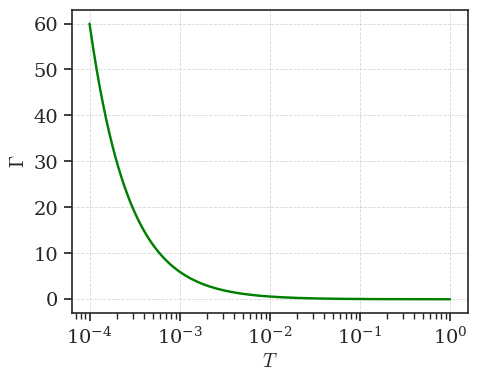

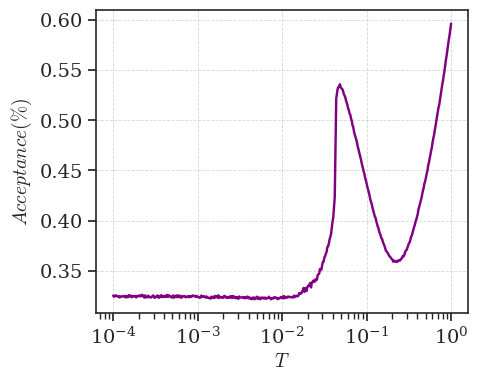

In [57]:
def get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters):
    energy_evolution_file = simulation_path / "heat_capacity.out"
    N = parameters['N']
    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['temperature', 'energy', 'cv', 'gamma', 'acc_ratio'])

    # Detection of the phase transition
    max_cv = df['cv'].max()
    Tc = df[df['cv'] == max_cv][['temperature', 'gamma']].values
    max_cv = df['cv'].max()
    Tc_val = Tc[0][0]
    gamma_val = Tc[0][1]
    cv_norm = max_cv / N

    results_dict = {
        'Tc': [Tc_val],
        'gamma': [gamma_val],
        'cv_max_norm': [cv_norm],
        'simulation': [simulation_path] 
    }

    df_results = pd.DataFrame(results_dict)

    output_csv = simulation_path / "result_simulation.csv"
    if not os.path.isfile(output_csv):
        df_results.to_csv(output_csv, index=False)
    else:
        df_results.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"Results saved in: {output_csv}")

    # E/N vs. T
    plt.figure()
    plt.plot(df['temperature'], df['energy']/N, label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$E/N$')
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "energy_per_particle_vs_temperature.pdf")
    plt.show()

    # Cv vs. T
    plt.figure()
    plt.plot(df['temperature'], df['cv']/N, color = 'red', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r' $C_v/N$')
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "cv_per_particle_vs_temperature.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(df['temperature'], df['gamma']/N, color = 'green', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$\Gamma$')
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "gamma_vs_temperature.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(df['temperature'], df['acc_ratio'], color = 'purple', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$Acceptance (\%)$')
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "acc_ratio_vs_temperature.pdf")
    plt.show()

get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters)   

Results saved in: gr_peaks_results.csv


<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_128865/1356197026.py:3: SyntaxWarning:

invalid escape sequence '\s'



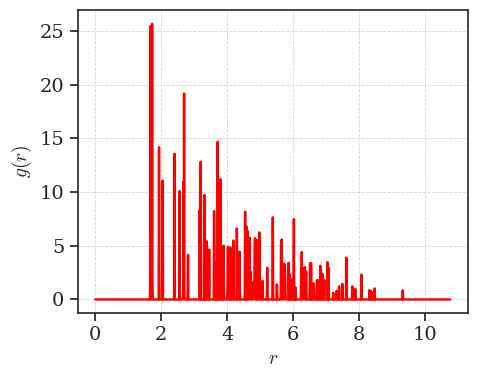

,r,Acc. Neigh
0,1.675,1
1,1.725,2
2,1.935,3
3,2.045,3
4,2.405,4
...,...,...
68,7.495,111
69,7.615,114
70,7.795,116
71,8.075,120


In [58]:
def get_gdr(simulation_path, parameters):
    gdr_file = simulation_path / "rdf.out"
    df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])
    rho = parameters['density']
    r = df['r'].to_numpy()
    gr = df['gr'].to_numpy()
    dr = r[1]-r[0]
    
    dNc = 4 * np.pi * (r**2) * rho * gr * dr
    Nc = np.cumsum(dNc)

    peak_idx, _ = find_peaks(gr, height=1.0)

    results = []
    for i, idx in enumerate(peak_idx):
        distance_r = r[idx]
        idx_end_peak = min(idx + 2, len(r) - 1) 
        acc_neigh = Nc[idx_end_peak]
        results.append({
            'r' : distance_r,
            'Acc. Neigh' : round(acc_neigh)
        })

    df_results = pd.DataFrame(results)
    output_csv = simulation_path / "gr_peaks_results.csv"

    if not os.path.isfile(output_csv):
        df_results.to_csv(output_csv, index=False)
    else:
        df_results.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"Results saved in: {output_csv}")

    # Plot 
    plt.figure()
    plt.plot(df['r'], df['gr'], color = 'red', label='Energía del sistema')
    plt.xlabel(r'$r$')
    plt.ylabel(r'$g(r)$')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "gdr.pdf")
    plt.show()

    return df_results

get_gdr(simulation_path, parameters)


In [59]:
# def get_structure_factor(simulation_path, parameters):
#     sq = simulation_path / "sq.out"
#     df = pd.read_csv(sq, sep='\s+', header=None, names=['q', 'sq',])

#     # Plot 
#     plt.figure()
#     plt.plot(df['q'], df['sq'], color = 'green', label='Energía del sistema')
#     plt.xlabel(r'$r$')
#     plt.ylabel(r'$g(r)$')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(simulation_path / "sq.pdf")
#     plt.show()

#     return df

# get_structure_factor(simulation_path, parameters)


In [60]:
def get_positions_plot(filename, saved_filename):

    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_atoms = int(lines[0])
    block_size = num_atoms + 2
    total_frames = len(lines) // block_size
    
    all_data = []
    for f in range(total_frames):
        start = f * block_size + 2
        end = start + num_atoms
        frame_coords = [l.split()[1:4] for l in lines[start:end]]
        
        df_frame = pd.DataFrame(frame_coords, columns=['x', 'y', 'z'], dtype=float)
        df_frame['frame'] = f  
        all_data.append(df_frame)

    df = pd.concat(all_data, ignore_index=True)

    last_frame = df[df['frame'] == df['frame'].max()]

    fig = px.scatter_3d(
        last_frame,
        x='x', y='y', z='z',
        opacity=1.0,
        template="plotly_white"
    )

    fig.update_traces(
        marker=dict(
            size=7,
            color='red',
            line=dict(width=0.5, color='black')
        )
    )

    # Box edges 
    xmin, ymin, zmin = last_frame[['x','y','z']].min()
    xmax, ymax, zmax = last_frame[['x','y','z']].max()

    edges = [
        ([xmin,xmax],[ymin,ymin],[zmin,zmin]),
        ([xmin,xmax],[ymax,ymax],[zmin,zmin]),
        ([xmin,xmax],[ymin,ymin],[zmax,zmax]),
        ([xmin,xmax],[ymax,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymax],[zmin,zmin]),
        ([xmax,xmax],[ymin,ymax],[zmin,zmin]),
        ([xmin,xmin],[ymin,ymax],[zmax,zmax]),
        ([xmax,xmax],[ymin,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymin],[zmin,zmax]),
        ([xmax,xmax],[ymin,ymin],[zmin,zmax]),
        ([xmin,xmin],[ymax,ymax],[zmin,zmax]),
        ([xmax,xmax],[ymax,ymax],[zmin,zmax])
    ]

    for ex, ey, ez in edges:
        fig.add_scatter3d(x=ex, y=ey, z=ez, mode='lines',
                        line=dict(color='black', width=4),
                        showlegend=False)

    fig.update_layout(
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, title='x'),
            yaxis=dict(showbackground=False, title='y'),
            zaxis=dict(showbackground=False, title='z'),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1.6, y=1.6, z=1.3)
            )
        ),
        title_x=0.5
    )

    # Positions array
    pos = last_frame[['x','y','z']].values

    # Bonds
    tree = cKDTree(pos)
    dists, _ = tree.query(pos, k=7)  
    a = np.median(dists[:,1])        
    pairs = tree.query_pairs(r=1.2*a)

    for i, j in pairs:
        fig.add_scatter3d(
            x=[pos[i,0], pos[j,0]],
            y=[pos[i,1], pos[j,1]],
            z=[pos[i,2], pos[j,2]],
            mode='lines',
            line=dict(color='black', width=1),
            opacity=0.5,
            showlegend=False
        )

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            yaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            zaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1.6, y=1.6, z=1.3)
            ),
            
        )
    )

    fig.show()
    fig.write_html(f"{saved_filename}.html")
    fig.write_image(f"{saved_filename}.pdf", scale=2, width=600, height=600)

    return 

filename = simulation_path / "final_position.xyz"
saved_filename = simulation_path / "positions"
get_positions_plot(filename, saved_filename)

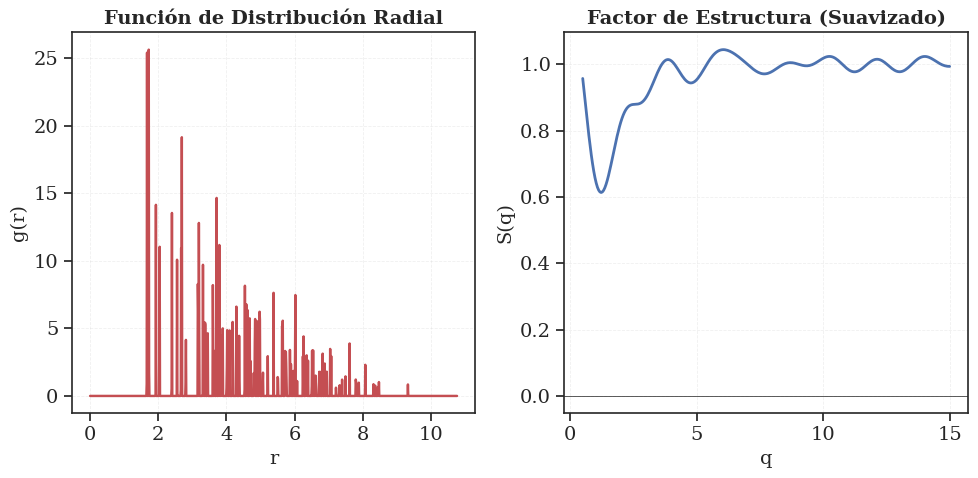

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_sq_smooth(rdf_file, density, L):
    # Cargar g(r)
    # Asumimos que rdf.out tiene dos columnas: r, g(r)
    data = np.loadtxt(rdf_file)
    r = data[:, 0]
    gr = data[:, 1]
    
    # Parámetros
    dr = r[1] - r[0]
    q = np.linspace(0.5, 15.0, 300) # Rango de q habitual
    sq = np.zeros_like(q)
    
    # Aplicamos una ventana de Lorch para suavizar el corte en L/2
    # Esto elimina las oscilaciones negativas falsas (Gibbs phenomenon)
    cutoff_index = np.searchsorted(r, L/2.0)
    r_cut = r[:cutoff_index]
    gr_cut = gr[:cutoff_index]
    
    # Factor de ventana (Lorch window)
    window = np.sinc(r_cut * np.pi / (L/2.0)) # sinc(x) = sin(pi*x)/(pi*x) en numpy
    
    for i, qi in enumerate(q):
        # Integral transformada: 1 + 4*pi*rho * Int( r^2 * (g(r)-1) * sin(qr)/qr )
        integrand = r_cut**2 * (gr_cut - 1.0) * (np.sin(qi * r_cut) / (qi * r_cut)) * window
        integral = np.trapezoid(integrand, r_cut)
        sq[i] = 1.0 + 4.0 * np.pi * density * integral
        
    return q, sq

# --- USO ---
# Asegúrate de poner la densidad correcta de tu simulación
rho = 0.1 
L_box = (64 / rho)**(1/3) # Recalcula L según tu N y rho
gdr_file = simulation_path / "rdf.out"
q, sq = calculate_sq_smooth(gdr_file, rho, L_box)

# Graficar
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
data = np.loadtxt(gdr_file) # Cargar para pintar g(r) también
plt.plot(data[:,0], data[:,1], 'r-', label='g(r) Simulación')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Función de Distribución Radial')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(q, sq, 'b-', lw=2, label='S(q) Calculado')
plt.xlabel('q')
plt.ylabel('S(q)')
plt.title('Factor de Estructura (Suavizado)')
plt.axhline(0, color='k', lw=0.5) # Línea base
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()